This is to try and calculating remaining capacity in various large areas over run 29.

In [1]:
%matplotlib inline
import pandas as pd
import pandana as pdna
from matplotlib import pyplot as plt
from urbansim.utils import misc, networks

store = pd.HDFStore('./../runs/run29.h5')
pd.options.mode.chained_assignment = None

/home/pksohn/.conda/envs/semcog_urbansim/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [36]:
from matplotlib import cm

In [2]:
p = store['base/parcels']
b = store['base/buildings']

In [3]:
# Set up walk network

with pd.HDFStore('./../data/semcog_networks.h5') as net_store:
    nodes = net_store['nodes_mgf14_ext_walk']
    edges = net_store['edges_mgf14_ext_walk']
    net = pdna.Network(nodes["x"], nodes["y"], 
                       edges["from"], edges["to"],
                       edges[['feet']])

In [4]:
# Get average prices in base year

nodes_walk = pd.DataFrame(index=net.node_ids)
bldg = b.loc[(81 <= b.building_type_id)
            & (b.building_type_id <= 84)
            & (0 < b.sqft_price_res)
            & (b.sqft_price_res < 500)]
bldg = bldg.merge(p[['nodeid_walk']], left_on='parcel_id', right_index=True)

net.set(bldg['nodeid_walk'], variable=bldg['sqft_price_res'])
nodes_walk['sqft_price_res'] = net.aggregate(2000, type='average', decay='flat')
res_prices = misc.reindex(nodes_walk.sqft_price_res, p.nodeid_walk)
p['res_prices'] = res_prices

In [5]:
# Get price deciles

for lid in p.large_area_id.unique():
    parcels_lid = p.loc[p.large_area_id == lid][['res_prices']]
    parcels_lid['res_decile'] = pd.qcut(parcels_lid['res_prices'], 10, labels=False)
    p.loc[p.large_area_id == lid, 'res_decile'] = parcels_lid.res_decile

In [6]:
# At this point, DataFrame "p" has deciles for residential price in each large area
# As well as max_dua
# Let's get the two series here:

max_dua = store['base/zoning'].max_dua
res_deciles = p.res_decile

In [23]:
dfs = {}

for year in range(2016, 2046):
    parcels = store['{}/parcels'.format(year)]
    feasibility = store['{}/feasibility'.format(year)]['residential']
    parcels['feasible'] = feasibility.max_profit_far > 0
    parcels['res_decile'] = res_deciles
    parcels = parcels[['feasible', 'res_decile', 'large_area_id']]
    
    result = parcels.groupby(['large_area_id', 'res_decile']).sum()
    dfs[year] = result

results = pd.concat(dfs.values(), keys=dfs.keys())

In [25]:
results.to_csv('run29_res_feasibility_by_price.csv')

In [26]:
lids = sorted(p.large_area_id.unique().tolist())

In [32]:
feasible = results.unstack(0)['feasible']

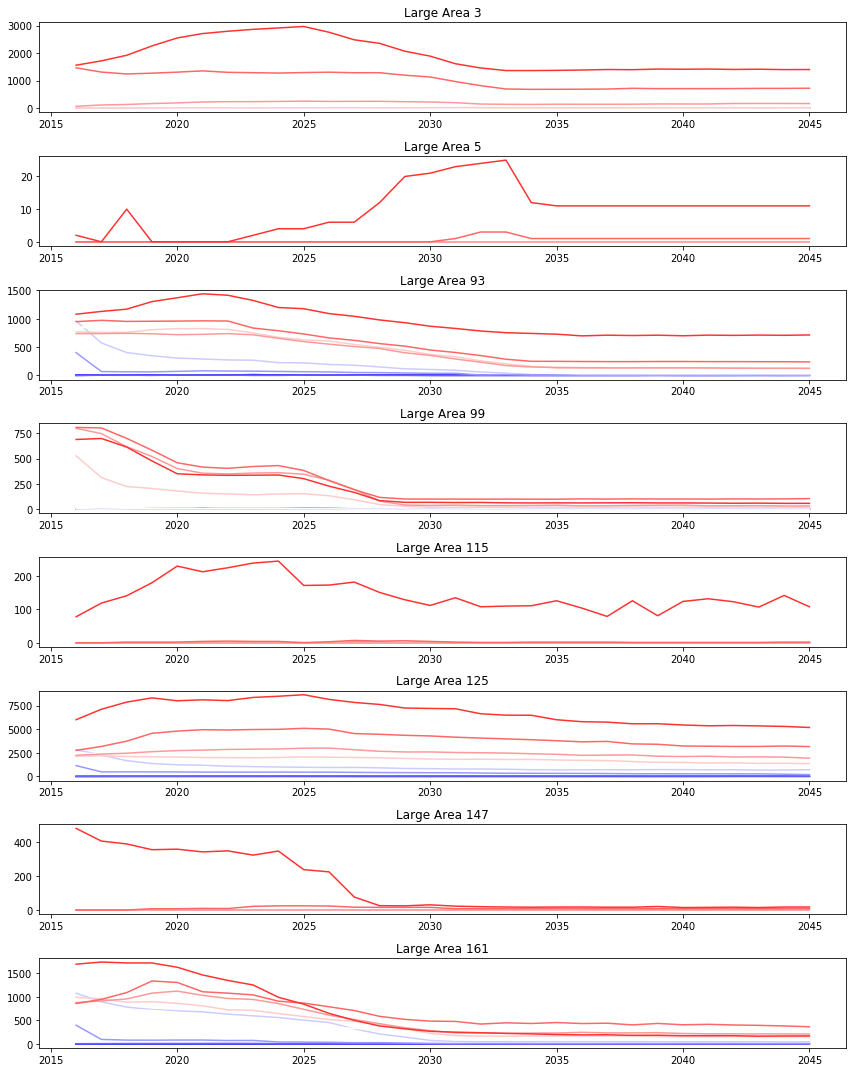

In [52]:
figure, axes_list = plt.subplots(len(p.large_area_id.unique()), 1, figsize=(12, 15))
for i, ax in enumerate(axes_list):
    lid_results = feasible.loc[lids[i]]
    ax.set_title('Large Area {}'.format(lids[i]))
    for d in range(10):
        row = lid_results.loc[d]
        ax.plot(row.index, row.values, color=cm.bwr(d/float(10)))
figure.tight_layout()

In [45]:
cm.Blues(0.3)

(0.71618608227604774, 0.83320261437908494, 0.91615532487504803, 1.0)

In [44]:
df= pd.read_csv('run29_res_capacity_2016.csv')

In [45]:
df

,large_area_id,res_decile,parcel_sqft,max_dua,max_units,res_units,unit_capacity
0,3,0.0,2.091512e+09,342408.228012,94148.616670,46803.0,22410.819535
1,3,1.0,8.078454e+08,233011.650349,102767.168968,50998.0,39663.518113
2,3,2.0,8.751223e+08,227984.570360,80137.566602,50987.0,18840.763491
3,3,3.0,7.037590e+08,244587.174451,70928.495253,46132.0,13839.787274
4,3,4.0,8.834404e+08,248207.088330,70181.179467,40993.0,13169.377021
5,3,5.0,1.307914e+09,236304.593752,96842.263101,47385.0,32691.510673
6,3,6.0,1.222072e+09,251992.296258,87839.207873,44515.0,26808.744802
7,3,7.0,1.333137e+09,230526.543661,103232.774706,49599.0,37961.519433
8,3,8.0,1.068311e+09,201417.661527,83161.681017,49390.0,14992.652504
9,3,9.0,1.108501e+09,155360.890552,61466.741985,43763.0,9057.629020
